Month Distribution:
Month
6     294
9     278
8     257
7     242
5     219
10    177
11    135
4     132
1     103
2      95
3      86
12     83
Name: count, dtype: int64

Season Distribution:
Season
Summer    793
Fall      590
Spring    437
Winter    281
Name: count, dtype: int64


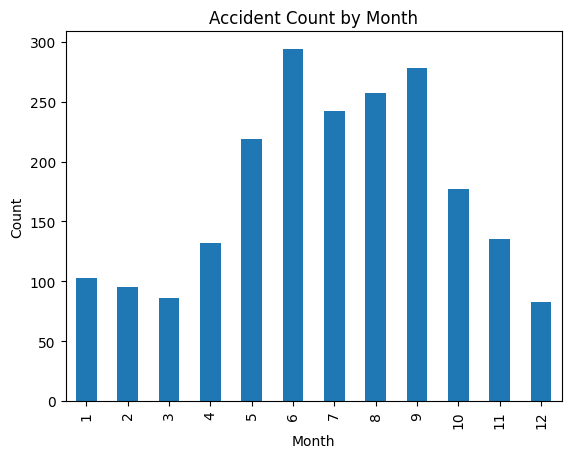

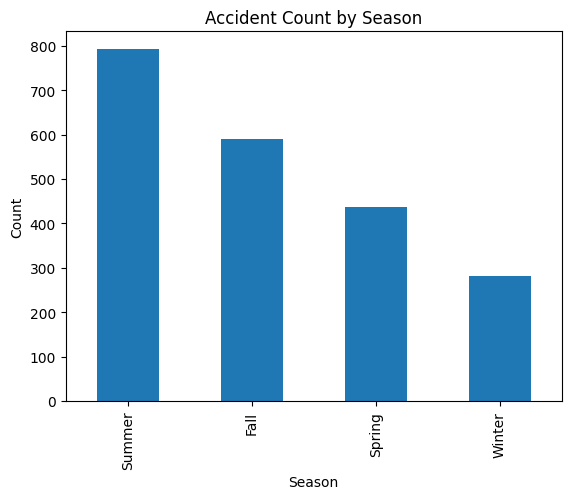

In [9]:
# Combine the large traffic dataset with the Motorcycle KSI dataset - trying to find another column
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the large traffic dataset
large_traffic_df = pd.read_csv("C:/Users/Sarah/OneDrive/Desktop/COMP309_GroupProject/data/large_traffic_dataset.csv")

# Filter for motorcycle PD only collisions and explicitly make a copy
motorcycle_pdo_df = large_traffic_df[
    (large_traffic_df['MOTORCYCLE'] == 'YES') & (large_traffic_df['PD_COLLISIONS'] == 'YES')
].copy()

# Seasonal grouping
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Add Season column
motorcycle_pdo_df['Month'] = pd.to_datetime(motorcycle_pdo_df['OCC_DATE']).dt.month
motorcycle_pdo_df['Season'] = motorcycle_pdo_df['Month'].apply(assign_season)

# Check distribution by month and season
print("Month Distribution:")
print(motorcycle_pdo_df['Month'].value_counts())
print("\nSeason Distribution:")
print(motorcycle_pdo_df['Season'].value_counts())

# One-hot encode Season
season_dummies = pd.get_dummies(motorcycle_pdo_df['Season'], prefix='Season')
motorcycle_pdo_df = pd.concat([motorcycle_pdo_df, season_dummies], axis=1)

# Visualize month distribution
motorcycle_pdo_df['Month'].value_counts().sort_index().plot(kind='bar', title='Accident Count by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

# Visualize seasonal trends
motorcycle_pdo_df['Season'].value_counts().plot(kind='bar', title='Accident Count by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.show()


In [11]:
# V2: Fresh Page for Updated Features
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load the datasets
large_traffic_df = pd.read_csv("C:/Users/Sarah/OneDrive/Desktop/COMP309_GroupProject/data/large_traffic_dataset.csv")
ksi_data = pd.read_csv("C:/Users/Sarah/OneDrive/Desktop/COMP309_GroupProject/data/ksi_dataset.csv")

# Preprocess the large traffic dataset (PD collisions only)
motorcycle_pdo_df = large_traffic_df[
    (large_traffic_df['MOTORCYCLE'] == 'YES') & (large_traffic_df['PD_COLLISIONS'] == 'YES')
].copy()

# Add calculated features to the PDO dataset
TORONTO_CENTER_LAT = 43.6532
TORONTO_CENTER_LONG = -79.3832
motorcycle_pdo_df['Distance_From_Center'] = np.sqrt(
    (motorcycle_pdo_df['LAT_WGS84'] - TORONTO_CENTER_LAT)**2 +
    (motorcycle_pdo_df['LONG_WGS84'] - TORONTO_CENTER_LONG)**2
)
motorcycle_pdo_df['Hour'] = motorcycle_pdo_df['OCC_HOUR']
motorcycle_pdo_df['DayOfWeek'] = pd.to_datetime(motorcycle_pdo_df['OCC_DATE']).dt.dayofweek
motorcycle_pdo_df['Month'] = pd.to_datetime(motorcycle_pdo_df['OCC_DATE']).dt.month
motorcycle_pdo_df['IsWeekend'] = motorcycle_pdo_df['DayOfWeek'].isin([5, 6]).astype(int)
motorcycle_pdo_df['Severity'] = 0  # Property damage-only

# Add Season column
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

motorcycle_pdo_df['Season'] = motorcycle_pdo_df['Month'].apply(assign_season)
season_dummies_pdo = pd.get_dummies(motorcycle_pdo_df['Season'], prefix='Season')
motorcycle_pdo_df = pd.concat([motorcycle_pdo_df, season_dummies_pdo], axis=1)

# Preprocess the KSI dataset
ksi_data['Distance_From_Center'] = np.sqrt(
    (ksi_data['LATITUDE'] - TORONTO_CENTER_LAT)**2 +
    (ksi_data['LONGITUDE'] - TORONTO_CENTER_LONG)**2
)
ksi_data['Hour'] = ksi_data['TIME'] // 100
ksi_data['DayOfWeek'] = pd.to_datetime(ksi_data['DATE']).dt.dayofweek
ksi_data['Month'] = pd.to_datetime(ksi_data['DATE']).dt.month
ksi_data['IsWeekend'] = ksi_data['DayOfWeek'].isin([5, 6]).astype(int)
ksi_data['Severity'] = 1  # Fatal/Injury collisions
ksi_data['Season'] = ksi_data['Month'].apply(assign_season)
season_dummies_ksi = pd.get_dummies(ksi_data['Season'], prefix='Season')
ksi_data = pd.concat([ksi_data, season_dummies_ksi], axis=1)

# Select shared features
selected_columns = [
    'Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'Distance_From_Center',
    'Season_Fall', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'Severity'
]
pdo_data = motorcycle_pdo_df[selected_columns]
ksi_data = ksi_data[selected_columns]

# Combine the datasets
combined_data = pd.concat([pdo_data, ksi_data], ignore_index=True)

# Split the data into features and target
X = combined_data.drop('Severity', axis=1)
y = combined_data['Severity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train a Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'
)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature importance
feature_importances = list(zip(X.columns, rf_model.feature_importances_))
print("\nFeature Importances:")
for feature, importance in feature_importances:
    print(f"{feature}: {importance}")



Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.70      0.76       420
           1       0.69      0.83      0.75       337

    accuracy                           0.76       757
   macro avg       0.76      0.76      0.76       757
weighted avg       0.77      0.76      0.76       757


Confusion Matrix:
 [[292 128]
 [ 56 281]]

Feature Importances:
Hour: 0.24420061332559503
DayOfWeek: 0.07737774979430032
Month: 0.13744125930176235
IsWeekend: 0.018977331019566876
Distance_From_Center: 0.44087069824979885
Season_Fall: 0.008342268961711405
Season_Spring: 0.007531268510911533
Season_Summer: 0.012305140446525883
Season_Winter: 0.05295367038982785


K-Means model has been saved as 'models/kmeans_model.pkl'


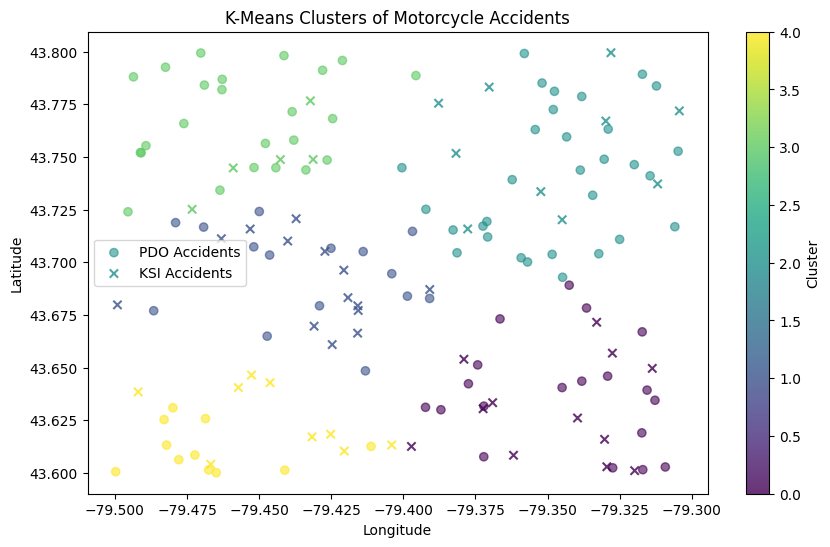

(Cluster
 2    31
 3    24
 0    19
 1    15
 4    11
 Name: count, dtype: int64,
 Cluster
 1    14
 0    12
 2    10
 4     9
 3     5
 Name: count, dtype: int64)

In [13]:
#Clustering with K-Means to group accidents into clusters that may represent 'hotspots'
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import pickle

# Dummy setup for demonstration since actual data isn't provided.
# In your context, you should replace this with the actual data loading process.
motorcycle_pdo_df = pd.DataFrame({
    'LAT_WGS84': np.random.uniform(43.6, 43.8, 100),  # Simulated latitude values
    'LONG_WGS84': np.random.uniform(-79.5, -79.3, 100),  # Simulated longitude values
})

ksi_data = pd.DataFrame({
    'LATITUDE': np.random.uniform(43.6, 43.8, 50),  # Simulated latitude values for KSI
    'LONGITUDE': np.random.uniform(-79.5, -79.3, 50),  # Simulated longitude values for KSI
})

# Combine latitude and longitude for clustering
coords = np.column_stack((motorcycle_pdo_df['LAT_WGS84'], motorcycle_pdo_df['LONG_WGS84']))

# Fit KMeans model for PDO dataset
kmeans = KMeans(n_clusters=5, random_state=42)
motorcycle_pdo_df['Cluster'] = kmeans.fit_predict(coords)

# Combine latitude and longitude for clustering in KSI dataset
ksi_coords = np.column_stack((ksi_data['LATITUDE'], ksi_data['LONGITUDE']))
ksi_data['Cluster'] = kmeans.predict(ksi_coords)

# Save the trained K-Means model
with open("C:/Users/Sarah/OneDrive/Desktop/COMP309_GroupProject/models/kmeans_model.pkl", "wb") as kmeans_file:
    pickle.dump(kmeans, kmeans_file)

print("K-Means model has been saved as 'models/kmeans_model.pkl'")


# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(
    motorcycle_pdo_df['LONG_WGS84'], motorcycle_pdo_df['LAT_WGS84'], 
    c=motorcycle_pdo_df['Cluster'], cmap='viridis', alpha=0.6, label="PDO Accidents"
)
plt.scatter(
    ksi_data['LONGITUDE'], ksi_data['LATITUDE'], 
    c=ksi_data['Cluster'], cmap='viridis', marker='x', alpha=0.8, label="KSI Accidents"
)
plt.colorbar(label="Cluster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clusters of Motorcycle Accidents")
plt.legend()
plt.show()

# Check cluster distribution
pdo_cluster_counts = motorcycle_pdo_df['Cluster'].value_counts()
ksi_cluster_counts = ksi_data['Cluster'].value_counts()

pdo_cluster_counts, ksi_cluster_counts

In [8]:
# Step 1: Incorporate K-Means Clusters into the Dataset
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Define constants
TORONTO_CENTER_LAT = 43.6532
TORONTO_CENTER_LONG = -79.3832

# Load datasets
large_traffic_df = pd.read_csv("C:/Users/sarah/AAASemester5Classes/COMP309DataFiles/Traffic_Collisions_Open_Data_1887845723801164272.csv")
ksi_data = pd.read_csv("C:/Users/sarah/AAASemester5Classes/COMP309DataFiles/MOTORCYCLIST_KSI.csv")

# Preprocess the PDO dataset
motorcycle_pdo_df = large_traffic_df[
    (large_traffic_df['MOTORCYCLE'] == 'YES') & (large_traffic_df['PD_COLLISIONS'] == 'YES')
].copy()

motorcycle_pdo_df['Distance_From_Center'] = np.sqrt(
    (motorcycle_pdo_df['LAT_WGS84'] - TORONTO_CENTER_LAT)**2 +
    (motorcycle_pdo_df['LONG_WGS84'] - TORONTO_CENTER_LONG)**2
)
motorcycle_pdo_df['Hour'] = motorcycle_pdo_df['OCC_HOUR']
motorcycle_pdo_df['Month'] = pd.to_datetime(motorcycle_pdo_df['OCC_DATE']).dt.month

# Preprocess the KSI dataset
ksi_data['Distance_From_Center'] = np.sqrt(
    (ksi_data['LATITUDE'] - TORONTO_CENTER_LAT)**2 +
    (ksi_data['LONGITUDE'] - TORONTO_CENTER_LONG)**2
)
ksi_data['Hour'] = ksi_data['TIME'] // 100
ksi_data['Month'] = pd.to_datetime(ksi_data['DATE']).dt.month

# Combine latitude and longitude for clustering
pdo_coords = np.column_stack((motorcycle_pdo_df['LAT_WGS84'], motorcycle_pdo_df['LONG_WGS84']))
ksi_coords = np.column_stack((ksi_data['LATITUDE'], ksi_data['LONGITUDE']))

# Fit K-Means model using the PDO dataset
kmeans = KMeans(n_clusters=5, random_state=42)
motorcycle_pdo_df['Cluster'] = kmeans.fit_predict(pdo_coords)
ksi_data['Cluster'] = kmeans.predict(ksi_coords)

# Add a binary Severity column to each dataset
motorcycle_pdo_df['Severity'] = 0  # Property damage-only
ksi_data['Severity'] = 1  # Fatal/Injury collisions

# Select shared features
selected_columns = [
    'Distance_From_Center', 'Hour', 'Month', 'Cluster', 'Severity'
]
pdo_data = motorcycle_pdo_df[selected_columns]
ksi_data = ksi_data[selected_columns]

# Combine the datasets
combined_data = pd.concat([pdo_data, ksi_data], ignore_index=True)

# Split the data into features and target
X = combined_data.drop('Severity', axis=1)
y = combined_data['Severity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'
)
rf_model.fit(X_train, y_train)

# Evaluate the Random Forest Model
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("\nRandom Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# Train a Logistic Regression Model
log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)

# Evaluate the Logistic Regression Model
y_pred_lr = log_reg.predict(X_test)
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
print("\nLogistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# Save the models for later use
import pickle

with open("rf_model_with_clusters.pkl", "wb") as rf_file:
    pickle.dump(rf_model, rf_file)

with open("log_reg_model_with_clusters.pkl", "wb") as lr_file:
    pickle.dump(log_reg, lr_file)


c:\Users\sarah\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(



Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.68      0.75       420
           1       0.68      0.82      0.74       337

    accuracy                           0.75       757
   macro avg       0.75      0.75      0.75       757
weighted avg       0.76      0.75      0.75       757


Random Forest Confusion Matrix:
 [[287 133]
 [ 60 277]]

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.41      0.51       420
           1       0.51      0.77      0.61       337

    accuracy                           0.57       757
   macro avg       0.60      0.59      0.56       757
weighted avg       0.61      0.57      0.56       757


Logistic Regression Confusion Matrix:
 [[171 249]
 [ 77 260]]


In [9]:
# Step 1: Test Individual Features for Predictive Power
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Define constants
TORONTO_CENTER_LAT = 43.6532
TORONTO_CENTER_LONG = -79.3832

# Load datasets
large_traffic_df = pd.read_csv("C:/Users/sarah/AAASemester5Classes/COMP309DataFiles/Traffic_Collisions_Open_Data_1887845723801164272.csv")
ksi_data = pd.read_csv("C:/Users/sarah/AAASemester5Classes/COMP309DataFiles/MOTORCYCLIST_KSI.csv")

# Preprocess the PDO dataset
motorcycle_pdo_df = large_traffic_df[
    (large_traffic_df['MOTORCYCLE'] == 'YES') & (large_traffic_df['PD_COLLISIONS'] == 'YES')
].copy()

motorcycle_pdo_df['Distance_From_Center'] = np.sqrt(
    (motorcycle_pdo_df['LAT_WGS84'] - TORONTO_CENTER_LAT)**2 +
    (motorcycle_pdo_df['LONG_WGS84'] - TORONTO_CENTER_LONG)**2
)
motorcycle_pdo_df['Hour'] = motorcycle_pdo_df['OCC_HOUR']
motorcycle_pdo_df['Month'] = pd.to_datetime(motorcycle_pdo_df['OCC_DATE']).dt.month

# Preprocess the KSI dataset
ksi_data['Distance_From_Center'] = np.sqrt(
    (ksi_data['LATITUDE'] - TORONTO_CENTER_LAT)**2 +
    (ksi_data['LONGITUDE'] - TORONTO_CENTER_LONG)**2
)
ksi_data['Hour'] = ksi_data['TIME'] // 100
ksi_data['Month'] = pd.to_datetime(ksi_data['DATE']).dt.month

# Combine latitude and longitude for clustering
pdo_coords = np.column_stack((motorcycle_pdo_df['LAT_WGS84'], motorcycle_pdo_df['LONG_WGS84']))
ksi_coords = np.column_stack((ksi_data['LATITUDE'], ksi_data['LONGITUDE']))

# Fit K-Means model using the PDO dataset
kmeans = KMeans(n_clusters=5, random_state=42)
motorcycle_pdo_df['Cluster'] = kmeans.fit_predict(pdo_coords)
ksi_data['Cluster'] = kmeans.predict(ksi_coords)

# Add a binary Severity column to each dataset
motorcycle_pdo_df['Severity'] = 0  # Property damage-only
ksi_data['Severity'] = 1  # Fatal/Injury collisions

# Function to train and evaluate models
def train_and_evaluate(features, label):
    combined_data = pd.concat([
        motorcycle_pdo_df[features + [label]],
        ksi_data[features + [label]]
    ], ignore_index=True)

    X = combined_data.drop(label, axis=1)
    y = combined_data[label]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Train Random Forest Classifier
    rf_model = RandomForestClassifier(
        n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'
    )
    rf_model.fit(X_train, y_train)

    y_pred_rf = rf_model.predict(X_test)
    print(f"\nRandom Forest Classification Report (Features: {features}):\n", classification_report(y_test, y_pred_rf))
    print(f"\nRandom Forest Confusion Matrix (Features: {features}):\n", confusion_matrix(y_test, y_pred_rf))

    # Train Logistic Regression Model
    log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    log_reg.fit(X_train, y_train)

    y_pred_lr = log_reg.predict(X_test)
    print(f"\nLogistic Regression Classification Report (Features: {features}):\n", classification_report(y_test, y_pred_lr))
    print(f"\nLogistic Regression Confusion Matrix (Features: {features}):\n", confusion_matrix(y_test, y_pred_lr))

# Test individual features
for feature in [['Distance_From_Center', 'Hour'], ['Distance_From_Center', 'Month'], ['Distance_From_Center', 'Cluster']]:
    train_and_evaluate(feature, 'Severity')


c:\Users\sarah\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(



Random Forest Classification Report (Features: ['Distance_From_Center', 'Hour']):
               precision    recall  f1-score   support

           0       0.80      0.69      0.74       420
           1       0.67      0.79      0.73       337

    accuracy                           0.73       757
   macro avg       0.74      0.74      0.73       757
weighted avg       0.74      0.73      0.74       757


Random Forest Confusion Matrix (Features: ['Distance_From_Center', 'Hour']):
 [[291 129]
 [ 72 265]]

Logistic Regression Classification Report (Features: ['Distance_From_Center', 'Hour']):
               precision    recall  f1-score   support

           0       0.70      0.34      0.46       420
           1       0.50      0.82      0.62       337

    accuracy                           0.55       757
   macro avg       0.60      0.58      0.54       757
weighted avg       0.61      0.55      0.53       757


Logistic Regression Confusion Matrix (Features: ['Distance_From_Cente

In [10]:
# Step 1: Test Individual and Combined Features for Predictive Power
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Define constants
TORONTO_CENTER_LAT = 43.6532
TORONTO_CENTER_LONG = -79.3832

# Load datasets
large_traffic_df = pd.read_csv("C:/Users/sarah/AAASemester5Classes/COMP309DataFiles/Traffic_Collisions_Open_Data_1887845723801164272.csv")
ksi_data = pd.read_csv("C:/Users/sarah/AAASemester5Classes/COMP309DataFiles/MOTORCYCLIST_KSI.csv")

# Preprocess the PDO dataset
motorcycle_pdo_df = large_traffic_df[
    (large_traffic_df['MOTORCYCLE'] == 'YES') & (large_traffic_df['PD_COLLISIONS'] == 'YES')
].copy()

motorcycle_pdo_df['Distance_From_Center'] = np.sqrt(
    (motorcycle_pdo_df['LAT_WGS84'] - TORONTO_CENTER_LAT)**2 +
    (motorcycle_pdo_df['LONG_WGS84'] - TORONTO_CENTER_LONG)**2
)
motorcycle_pdo_df['Hour'] = motorcycle_pdo_df['OCC_HOUR']
motorcycle_pdo_df['Month'] = pd.to_datetime(motorcycle_pdo_df['OCC_DATE']).dt.month

# Preprocess the KSI dataset
ksi_data['Distance_From_Center'] = np.sqrt(
    (ksi_data['LATITUDE'] - TORONTO_CENTER_LAT)**2 +
    (ksi_data['LONGITUDE'] - TORONTO_CENTER_LONG)**2
)
ksi_data['Hour'] = ksi_data['TIME'] // 100
ksi_data['Month'] = pd.to_datetime(ksi_data['DATE']).dt.month

# Combine latitude and longitude for clustering
pdo_coords = np.column_stack((motorcycle_pdo_df['LAT_WGS84'], motorcycle_pdo_df['LONG_WGS84']))
ksi_coords = np.column_stack((ksi_data['LATITUDE'], ksi_data['LONGITUDE']))

# Fit K-Means model using the PDO dataset
kmeans = KMeans(n_clusters=5, random_state=42)
motorcycle_pdo_df['Cluster'] = kmeans.fit_predict(pdo_coords)
ksi_data['Cluster'] = kmeans.predict(ksi_coords)

# Add a binary Severity column to each dataset
motorcycle_pdo_df['Severity'] = 0  # Property damage-only
ksi_data['Severity'] = 1  # Fatal/Injury collisions

# Function to train and evaluate models
def train_and_evaluate(features, label):
    combined_data = pd.concat([
        motorcycle_pdo_df[features + [label]],
        ksi_data[features + [label]]
    ], ignore_index=True)

    X = combined_data.drop(label, axis=1)
    y = combined_data[label]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Train Random Forest Classifier
    rf_model = RandomForestClassifier(
        n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'
    )
    rf_model.fit(X_train, y_train)

    y_pred_rf = rf_model.predict(X_test)
    print(f"\nRandom Forest Classification Report (Features: {features}):\n", classification_report(y_test, y_pred_rf))
    print(f"\nRandom Forest Confusion Matrix (Features: {features}):\n", confusion_matrix(y_test, y_pred_rf))

    # Train Gradient Boosting Classifier
    gb_model = GradientBoostingClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42
    )
    gb_model.fit(X_train, y_train)

    y_pred_gb = gb_model.predict(X_test)
    print(f"\nGradient Boosting Classification Report (Features: {features}):\n", classification_report(y_test, y_pred_gb))
    print(f"\nGradient Boosting Confusion Matrix (Features: {features}):\n", confusion_matrix(y_test, y_pred_gb))

# Test individual features
for feature in [['Distance_From_Center', 'Hour'], ['Distance_From_Center', 'Month'], ['Distance_From_Center', 'Cluster']]:
    train_and_evaluate(feature, 'Severity')

# Test combination of all features
train_and_evaluate(['Distance_From_Center', 'Hour', 'Month', 'Cluster'], 'Severity')


c:\Users\sarah\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(



Random Forest Classification Report (Features: ['Distance_From_Center', 'Hour']):
               precision    recall  f1-score   support

           0       0.80      0.69      0.74       420
           1       0.67      0.79      0.73       337

    accuracy                           0.73       757
   macro avg       0.74      0.74      0.73       757
weighted avg       0.74      0.73      0.74       757


Random Forest Confusion Matrix (Features: ['Distance_From_Center', 'Hour']):
 [[291 129]
 [ 72 265]]

Gradient Boosting Classification Report (Features: ['Distance_From_Center', 'Hour']):
               precision    recall  f1-score   support

           0       0.83      0.79      0.81       420
           1       0.75      0.79      0.77       337

    accuracy                           0.79       757
   macro avg       0.79      0.79      0.79       757
weighted avg       0.79      0.79      0.79       757


Gradient Boosting Confusion Matrix (Features: ['Distance_From_Center', 

c:\Users\sarah\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Final Gradient Boosting Model Performance:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       420
           1       0.75      0.86      0.80       337

    accuracy                           0.81       757
   macro avg       0.81      0.82      0.81       757
weighted avg       0.82      0.81      0.81       757

Confusion Matrix:
[[322  98]
 [ 46 291]]


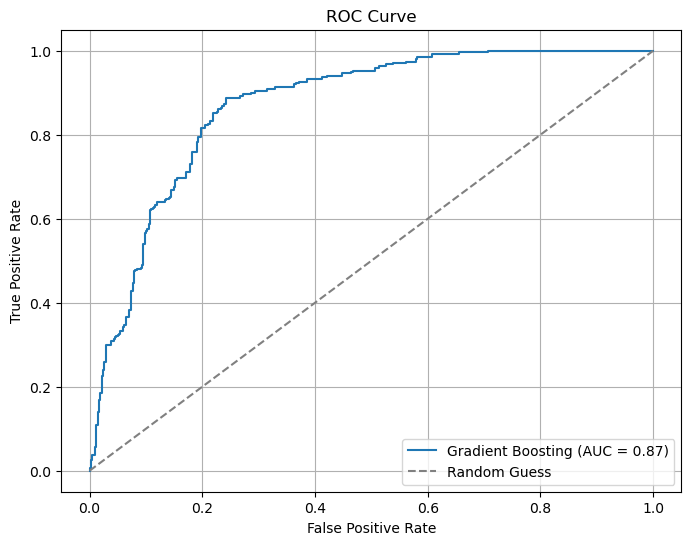

Model has been saved as 'final_gradient_boosting_model.pkl'


In [12]:
# Export the Final Gradient Boosting Model for Application
import pickle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reload and preprocess the combined dataset
TORONTO_CENTER_LAT = 43.6532
TORONTO_CENTER_LONG = -79.3832

# Load datasets
large_traffic_df = pd.read_csv("C:/Users/sarah/AAASemester5Classes/COMP309DataFiles/Traffic_Collisions_Open_Data_1887845723801164272.csv")
ksi_data = pd.read_csv("C:/Users/sarah/AAASemester5Classes/COMP309DataFiles/MOTORCYCLIST_KSI.csv")

# Preprocess the PDO dataset
motorcycle_pdo_df = large_traffic_df[
    (large_traffic_df['MOTORCYCLE'] == 'YES') & (large_traffic_df['PD_COLLISIONS'] == 'YES')
].copy()

motorcycle_pdo_df['Distance_From_Center'] = np.sqrt(
    (motorcycle_pdo_df['LAT_WGS84'] - TORONTO_CENTER_LAT)**2 +
    (motorcycle_pdo_df['LONG_WGS84'] - TORONTO_CENTER_LONG)**2
)
motorcycle_pdo_df['Hour'] = motorcycle_pdo_df['OCC_HOUR']
motorcycle_pdo_df['Month'] = pd.to_datetime(motorcycle_pdo_df['OCC_DATE']).dt.month

# Preprocess the KSI dataset
ksi_data['Distance_From_Center'] = np.sqrt(
    (ksi_data['LATITUDE'] - TORONTO_CENTER_LAT)**2 +
    (ksi_data['LONGITUDE'] - TORONTO_CENTER_LONG)**2
)
ksi_data['Hour'] = ksi_data['TIME'] // 100
ksi_data['Month'] = pd.to_datetime(ksi_data['DATE']).dt.month

# Combine latitude and longitude for clustering
pdo_coords = np.column_stack((motorcycle_pdo_df['LAT_WGS84'], motorcycle_pdo_df['LONG_WGS84']))
ksi_coords = np.column_stack((ksi_data['LATITUDE'], ksi_data['LONGITUDE']))

# Fit K-Means model using the PDO dataset
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
motorcycle_pdo_df['Cluster'] = kmeans.fit_predict(pdo_coords)
ksi_data['Cluster'] = kmeans.predict(ksi_coords)

# Add a binary Severity column to each dataset
motorcycle_pdo_df['Severity'] = 0  # Property damage-only
ksi_data['Severity'] = 1  # Fatal/Injury collisions

# Combine the datasets
combined_data = pd.concat([
    motorcycle_pdo_df[['Distance_From_Center', 'Hour', 'Month', 'Cluster', 'Severity']],
    ksi_data[['Distance_From_Center', 'Hour', 'Month', 'Cluster', 'Severity']]
], ignore_index=True)

# Split the data
X = combined_data.drop('Severity', axis=1)
y = combined_data['Severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the Gradient Boosting model
final_gb_model = GradientBoostingClassifier(
    n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42
)
final_gb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = final_gb_model.predict(X_test)
y_pred_proba = final_gb_model.predict_proba(X_test)[:, 1]
print("Final Gradient Boosting Model Performance:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC Analysis
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Gradient Boosting (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Save the model
with open("final_gradient_boosting_model.pkl", "wb") as model_file:
    pickle.dump(final_gb_model, model_file)

print("Model has been saved as 'final_gradient_boosting_model.pkl'")




Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.68      0.75       420
           1       0.68      0.82      0.74       337

    accuracy                           0.75       757
   macro avg       0.75      0.75      0.75       757
weighted avg       0.76      0.75      0.75       757


Random Forest Confusion Matrix:
 [[287 133]
 [ 60 277]]

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.41      0.51       420
           1       0.51      0.77      0.61       337

    accuracy                           0.57       757
   macro avg       0.60      0.59      0.56       757
weighted avg       0.61      0.57      0.56       757


Logistic Regression Confusion Matrix:
 [[171 249]
 [ 77 260]]


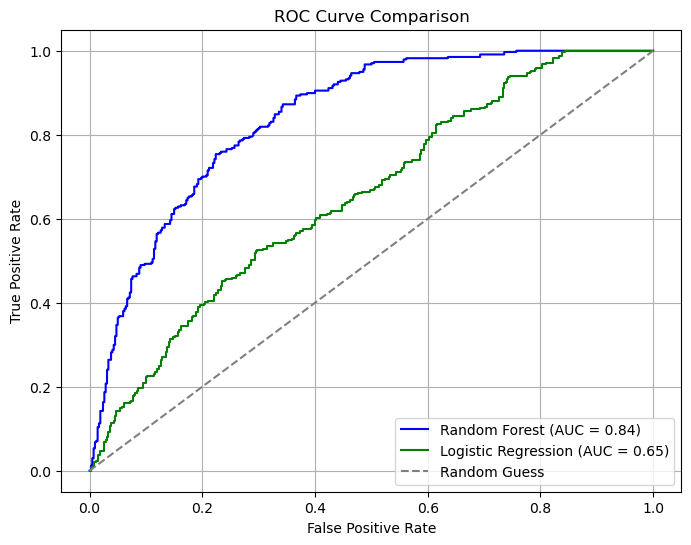

In [13]:
# Train a Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'
)
rf_model.fit(X_train, y_train)

# Evaluate the Random Forest Model
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_proba = rf_model.predict_proba(X_test)[:, 1]  # For ROC curve
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("\nRandom Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# Train a Logistic Regression Model
log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)

# Evaluate the Logistic Regression Model
y_pred_lr = log_reg.predict(X_test)
y_pred_lr_proba = log_reg.predict_proba(X_test)[:, 1]  # For ROC curve
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
print("\nLogistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# ROC Analysis
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_proba)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr_proba)
auc_rf = roc_auc_score(y_test, y_pred_rf_proba)
auc_lr = roc_auc_score(y_test, y_pred_lr_proba)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", color='blue')
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})", color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()
